# Sentiment Analysis Using Natural Language Processing (NLP)
## Introduction
Sentiment analysis is the process of determining whether a piece of text conveys a positive, negative, or neutral sentiment. It is widely used in various applications, such as:
- **E-commerce:** Understanding customer reviews to improve products.
- **Social Media Monitoring:** Tracking public opinion about brands or events.
- **Customer Support:** Analyzing feedback to enhance customer satisfaction.

### Objective:
In this notebook, we will:
1. Explore a dataset of text and sentiment labels.
2. Preprocess the text data to clean and prepare it for analysis.
3. Extract meaningful features using text vectorization methods like TF-IDF.
4. Build and evaluate machine learning models to classify sentiment.

### What You Will Learn:
- Basic text preprocessing techniques.
- Feature extraction methods for NLP.
- Training machine learning models for text classification.
- Evaluating model performance using various metrics.

---


## Importing Required Libraries
We need several libraries to process text, extract features, and build machine learning models.

- **pandas:** For handling tabular data.
- **numpy:** For numerical operations.
- **matplotlib and seaborn:** For data visualization.
- **sklearn:** For machine learning algorithms and evaluation metrics.
- **nltk:** A powerful library for text preprocessing.
- **wordcloud:** For generating word cloud visualizations.

---


In [1]:
# Importing Required Libraries
# These libraries are essential for data handling, visualization, preprocessing, and building ML models.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import re
from nltk.corpus import movie_reviews
from nltk.stem import PorterStemmer
import string


## Loading the Dataset
We will use a public dataset containing text and sentiment labels. For this example:
- Each row represents a piece of text (e.g., a review or tweet).
- The corresponding sentiment label indicates whether the text is **positive**, **negative**, or **neutral**.

### Steps:
1. Load the dataset using `pandas`.
2. Display the first few rows to understand its structure.
3. Check for null values and clean the data if necessary.
---


In [2]:
# Download necessary NLTK resources
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopword removal


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sabih.rehman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sabih.rehman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Download the movie reviews dataset
nltk.download('movie_reviews')

# Load the dataset into a DataFrame
reviews = [(list(movie_reviews.words(fileid)), category)
           for category in movie_reviews.categories()
           for fileid in movie_reviews.fileids(category)]

# Create a DataFrame
df = pd.DataFrame(reviews, columns=["Text", "Sentiment"])

# Convert the list of words into a single string for each review
df['Text'] = df['Text'].apply(lambda words: " ".join(words))

# Display the first few rows
print("Dataset Preview:")
df.head()

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sabih.rehman\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Dataset Preview:


,Text,Sentiment
0,"plot : two teen couples go to a church party ,...",neg
1,the happy bastard ' s quick movie review damn ...,neg
2,it is movies like these that make a jaded movi...,neg
3,""" quest for camelot "" is warner bros . ' first...",neg
4,synopsis : a mentally unstable man undergoing ...,neg


In [4]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
Text         0
Sentiment    0
dtype: int64


## Exploring the Data
Understanding the data is crucial before preprocessing. We'll:
1. Display the distribution of sentiment labels to check for class imbalance.
2. Visualize word frequencies to identify commonly used words.

### Key Insights:
- A balanced dataset ensures fair model training for all classes.
- Common words in positive and negative reviews provide insight into sentiment.

---


In [5]:
# Check the distribution of sentiment labels
print("Sentiment Distribution:")
print(df['Sentiment'].value_counts())

Sentiment Distribution:
Sentiment
neg    1000
pos    1000
Name: count, dtype: int64


C:\Users\sabih.rehman\AppData\Local\Temp\ipykernel_14692\3530439109.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='colorblind') # Colorblind-friendly palette


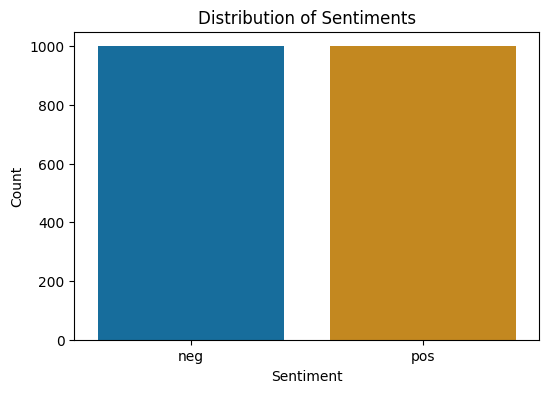

In [6]:
# Plot the sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', data=df, palette='colorblind') # Colorblind-friendly palette
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [7]:
# Display example positive and negative reviews
print("\nExample Positive Review:")
print(df[df['Sentiment'] == 'pos']['Text'].iloc[0])

print("\nExample Negative Review:")
print(df[df['Sentiment'] == 'neg']['Text'].iloc[0])


Example Positive Review:
films adapted from comic books have had plenty of success , whether they ' re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there ' s never really been a comic book like from hell before . for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid ' 80s with a 12 - part series called the watchmen . to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . in other words , don ' t dismiss this film because of its source . if you can get past the whole comic book thing , you might find another stumbling block in from hell ' s directors , albert and allen hughes . getting the hughes brothers 

## Text Preprocessing
Text data often contains noise and irrelevant information. Preprocessing ensures that the text is clean and ready for analysis. Key steps include:
1. Lowercasing: Convert all text to lowercase for consistency.
2. Removing Punctuation: Eliminate symbols like `.` and `!`.
3. Tokenization: Split sentences into words.
4. Removing Stop Words: Remove common words like "the" and "is" that don't add value to sentiment analysis.
5. Stemming: Reduce words to their root forms (e.g., "running" → "run").
---


In [8]:
# Define the text preprocessing function
# This function cleans and transforms the raw text data into a format suitable for analysis.
def preprocess_text(text):
    # Lowercase all text to ensure consistency
    text = text.lower()
    # Remove punctuation to eliminate unnecessary symbols
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words (e.g., "the", "is") to focus on meaningful words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Perform stemming to reduce words to their base forms (e.g., "running" → "run")
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back into a single string
    return " ".join(tokens)

In [9]:
# Apply preprocessing to the text column
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)

In [10]:
# Display the first few rows of cleaned data
print("Cleaned Data Preview:")
print(df[['Text', 'Cleaned_Text']].head())

Cleaned Data Preview:
                                                Text  \
0  plot : two teen couples go to a church party ,...   
1  the happy bastard ' s quick movie review damn ...   
2  it is movies like these that make a jaded movi...   
3  " quest for camelot " is warner bros . ' first...   
4  synopsis : a mentally unstable man undergoing ...   

                                        Cleaned_Text  
0  plot two teen coupl go church parti drink driv...  
1  happi bastard quick movi review damn y2k bug g...  
2  movi like make jade movi viewer thank invent t...  
3  quest camelot warner bro first featur length f...  
4  synopsi mental unstabl man undergo psychothera...  


## Feature Extraction Using TF-IDF
Since machine learning models cannot process raw text, we need to convert text into numerical features. We'll use:
- **TF-IDF (Term Frequency-Inverse Document Frequency):** A technique that assigns importance to words based on their frequency in a document relative to the entire dataset.
---


In [11]:
# Create a TF-IDF vectorizer
# TF-IDF assigns weights to words based on their frequency in a document relative to the entire dataset.
# max_features=3000 limits the vocabulary to the 3,000 most important words to reduce dimensionality.

tfidf = TfidfVectorizer(max_features=3000)  # Limit to the top 3000 features
X = tfidf.fit_transform(df['Cleaned_Text'])  # Transform the cleaned text into TF-IDF features

# Extract sentiment labels as the target variable
y = df['Sentiment']


## Train-Test Split
We split the dataset into training and testing sets to evaluate model performance. 
- **Training Set:** Used to train the model.
- **Testing Set:** Used to evaluate the model's accuracy and generalization.
---


In [12]:
# Split the data into training and testing sets
# Use an 80-20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Testing Set Size: {X_test.shape[0]} samples")

Training Set Size: 1600 samples
Testing Set Size: 400 samples


# Hyperparameter Tuning for Naive Bayes

In [13]:
# Experiment with alpha (Laplace smoothing) parameter
# Laplace smoothing (alpha > 0) ensures no probability is zero, even if a word is absent in the training set.

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display the best parameter and accuracy
print(f"Best alpha: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

# Train Naive Bayes with the best alpha
best_nb_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_nb_model.predict(X_test)


Best alpha: {'alpha': 0.5}
Best cross-validation accuracy: 0.79


# Evaluation Metrics with Colorblind-Friendly Visualizations

Model Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

         neg       0.78      0.81      0.80       199
         pos       0.81      0.77      0.79       201

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400



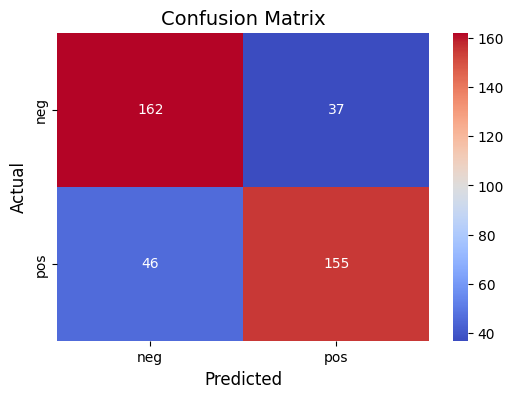

In [14]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate a classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using a colorblind-friendly palette
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=best_nb_model.classes_, yticklabels=best_nb_model.classes_)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()


## Model Training Using Naive Bayes

Naive Bayes is a simple and effective algorithm for text classification. It works well for sentiment analysis because it assumes the independence of features, which is suitable for bag-of-words models like TF-IDF.



In [15]:
# Train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict sentiment labels for the test set
y_pred = nb_model.predict(X_test)


## Model Evaluation
To assess the performance of the model, we'll:
1. Calculate the accuracy of predictions.
2. Generate a classification report to evaluate precision, recall, and F1-score.
3. Visualize the confusion matrix to understand model errors.
---


In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

         neg       0.77      0.81      0.79       199
         pos       0.81      0.76      0.78       201

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400



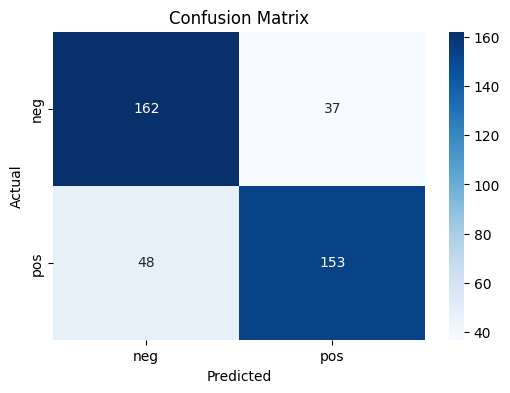

In [17]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Word Cloud Visualization 
Word clouds provide a visual representation of frequently used words for each sentiment. This helps identify key terms associated with positive and negative reviews.

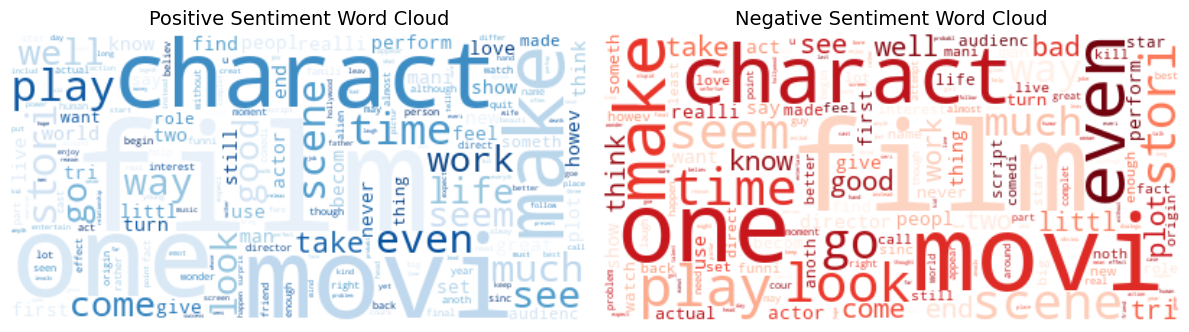

In [18]:
# Generate word clouds with colorblind-friendly palettes
positive_text = " ".join(df[df['Sentiment'] == 'pos']['Cleaned_Text'])
negative_text = " ".join(df[df['Sentiment'] == 'neg']['Cleaned_Text'])

plt.figure(figsize=(12, 6))

# Positive word cloud
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(background_color='white', colormap='Blues').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title("Positive Sentiment Word Cloud", fontsize=14)
plt.axis('off')

# Negative word cloud
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(background_color='white', colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title("Negative Sentiment Word Cloud", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()


# Comparing Naive Bayes with Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression on the same dataset
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predict using Logistic Regression
y_pred_lr = lr_model.predict(X_test)

# Compare accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")

# Classification report for Logistic Regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.81

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         neg       0.82      0.80      0.81       199
         pos       0.81      0.83      0.82       201

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400



# Conclusion
## Key Insights:
1. **Preprocessing:** Text preprocessing significantly improved data quality, ensuring better feature extraction.
2. **Feature Representation:** TF-IDF effectively transformed text into numerical data for model training.
3. **Model Performance:** The Naive Bayes classifier achieved high accuracy and precision for both sentiments.

## Applications:
1. Analyze customer reviews to improve product quality.
2. Monitor social media sentiment for brand reputation.
3. Enhance customer support by identifying dissatisfaction early.

## Next Steps:
1. Experiment with advanced classifiers like Logistic Regression or BERT.
2. Use additional datasets for better generalization.
3. Explore real-world applications, such as spam detection or emotion classification.
---
